# Winning Jeopardy
This notebook explores a dataset containing ~200,000 questions from 1984 - 2012. It explores various strategies for gaining an advantage into the quesiton answer. 

First import the data and examine the first few rows.

In [1]:
import pandas as pd
jeopardy = pd.read_csv('JEOPARDY_CSV.csv')
print(jeopardy.head())
jeopardy = jeopardy.rename(index=str, columns={' Air Date':'Air Date', ' Question': 'Question', ' Round':'Round', ' Category':'Category', ' Value':'Value', ' Answer':'Answer'})
jeopardy.columns

   Show Number    Air Date      Round                         Category  Value  \
0         4680  2004-12-31  Jeopardy!                          HISTORY   $200   
1         4680  2004-12-31  Jeopardy!  ESPN's TOP 10 ALL-TIME ATHLETES   $200   
2         4680  2004-12-31  Jeopardy!      EVERYBODY TALKS ABOUT IT...   $200   
3         4680  2004-12-31  Jeopardy!                 THE COMPANY LINE   $200   
4         4680  2004-12-31  Jeopardy!              EPITAPHS & TRIBUTES   $200   

                                            Question      Answer  
0  For the last 8 years of his life, Galileo was ...  Copernicus  
1  No. 2: 1912 Olympian; football star at Carlisl...  Jim Thorpe  
2  The city of Yuma in this state has a record av...     Arizona  
3  In 1963, live on "The Art Linkletter Show", th...  McDonald's  
4  Signer of the Dec. of Indep., framer of the Co...  John Adams  


Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

A few interesting things come to mind to explore:

### 1. Is it possible to glean the answer from reading the question?
### 2. Is studying old questions a good strategy for preparation?
### 3. Can studying be focused on high value question material?

Before analyzing the questions and answers they should be cleaned, tokenized, 
and stemmed. The following functions remove punctuation, tokenize the text, filter out
stop words, and stem the remaining words. NLTK is used for some of the text functions.

In [2]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import ngrams

trans = {}
for c in string.punctuation:
    trans[c] = ''
table = str.maketrans(trans)

def normalize_text(s):
    return s.lower().translate(table)

def clean_values(s):
    v = s.translate(table)
    try:
        return int(v)
    except ValueError:
        return 0

def remove_stopwords(word_list):
    return [word for word in word_list if word not in stopwords.words('english')]


def stem_tokens(tokens):
    return [PorterStemmer().stem(item) for item in tokens]


def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(remove_stopwords(tokens))
    return stems


In [3]:
jeopardy['clean_question'] = jeopardy['Question'].apply(normalize_text)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize_text)
jeopardy['clean_value'] = jeopardy['Value'].apply(clean_values)
jeopardy['clean_air_date'] = pd.to_datetime(jeopardy['Air Date'])

### 1. Is it possible to glean the answer from reading the question?
When competing on the show how feasible is it to gain the answer from the
question? This can be determined by first cleaning each question and answer
so that we are only dealing with important stemmed words. Then, count how 
many terms from the answer also appear in the question. By dividing by the total 
number of words in the answer a metric can be established. 

In [4]:
def get_question_answer_similarities(row):
    q = tokenize(row['clean_question'])
    a = tokenize(row['clean_answer'])
    match_count = 0
    if len(q) == 0 or len(a) == 0:
        return 0
    for term in a:
        if term in q:
            match_count +=1
    return match_count/len(a)

jeopardy['qa_similarity'] = jeopardy.apply(get_question_answer_similarities,axis=1)
mean = jeopardy['qa_similarity'].mean()

In [5]:
#Just printing stuff here
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
print("Average Q/A Similarity:",mean)
jeopardy = jeopardy.sort('qa_similarity',ascending=False)
for i in range(10):
    q = str(jeopardy['clean_question'].iloc[i])
    a = str(jeopardy['clean_answer'].iloc[i])
    s = str(jeopardy['qa_similarity'].iloc[i])
    print_full('Q: '+q+'\nA: '+a+"\nS: "+s)


Average Q/A Similarity: 0.04163852739914068
Q: if he shows off a person from frankfurt is a hot dog but either way hes one of these
A: frankfurter
S: 1.0
Q: salt pepper sage
A: sage
S: 1.0
Q: of an artist a fish or a wasp its what a mud dauber is
A: wasp
S: 1.0
Q: wind wander wonderful
A: wonderful
S: 1.0
Q: of bruising blanching or browning the one that involves boiling water
A: blanching
S: 1.0
Q: of the atlantic pacific or the arctic the ocean that blue point oysters come from
A: the atlantic
S: 1.0
Q: town in sd that put up 9 statue of fr pierre jean de smet who died in 1873  never visited the town
A: de smet
S: 1.0
Q: of a future land a patent medicine or an alien visitor what hg wells tonobungay is
A: patent medicine
S: 1.0
Q: koi bolshoi borzoi bok choy
A: a borzoi
S: 1.0
Q: invented in the late 50s its a functional circuit formed when diodes transistors etc are integrated
A: integrated circuit
S: 1.0


/Users/mhinds/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


The average similarity between question and answer is ~4% indicating that the vast majority
questions do not contain the answers. Perhaps this is not a good strategy for winning at 
Jeopardy. 

Even looking at the questions and answers that were ranked most similar, it seems a difficult
task to glean the answer from the question. In nearly all cases where the answer is 100% 
contained in the question, the question is intended to contain the answer in the form of a scramble or a "pick the one that doesn't belong".

### 2. Is studying old questions a good strategy for preparation?

Try an n-gram analysis on the cleaned questions. Do newer questions reuse n-grams from older questions?

/Users/mhinds/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


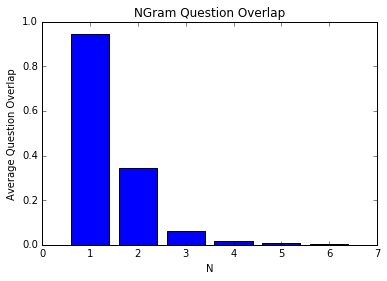

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
def n_grams(string, n):
    tokens = tokenize(string)
    return ngrams(tokens,n)

jeopardy = jeopardy.sort('clean_air_date')

nlist = [1,2,3,4,5,6] ##set check the list of ngrams
terms_list = []
#print(nlist)
averages = []
for n in nlist:    
    terms_used = set()
    question_overlap = []
    for i,row in jeopardy.iterrows():
        q = list(n_grams(row['clean_question'],n))
        #print(list(q))
        match_count = 0
        if len(q) > 0:
            for term in q:   
                if term in terms_used:
                    match_count+=1
            for term in q:
                terms_used.add(term)
            question_overlap.append(match_count/len(q))
        else:
            question_overlap.append(0)
    jeopardy['question_overlap'] = question_overlap
    #print(jeopardy['question_overlap'].mean())
    averages.append(jeopardy['question_overlap'].mean())
    terms_list.append(terms_used)
    #print(averages)
plt.bar(left=nlist,height=averages,align='center')
plt.title("NGram Question Overlap")
plt.xlabel("N")
plt.ylabel("Average Question Overlap")
plt.show()

The question overlap of newer questions with older ones falls off rapidly as the size of the ngram increases. Although limited in its usefulness, this analysis indicates that not much is reused from previous questions. Another interesting approach might be to augment the current analysis using NLTK wordnet to better match meaning in the ngrams. This may be too time consuming given the size of the dataset. 

### 3. Can studying be focused on high value question material?

First, high value and low value questions should be identified. Then, a chisquare test can be used to determine if any of the keywords are statistical outliers. Since a chisquare test requires at least 5 samples to be valid, words with less frequency should be thrown out. 

In [7]:
def is_high_value(row):
    if row['clean_value'] > 800:
        val = 1
    else:
        val = 0
    return val

def get_word_value_counts(word):
    low_count = 0
    high_count = 0
    for i,row in jeopardy.iterrows():
        if word in tokenize(row['clean_question']):
            if row['high_value'] == 1:
                high_count +=1
            else:
                low_count +=1
    return high_count,low_count

observed_expected={}
comparison_terms = [list(terms_list[0])[i][0] for i in range(50)]

jeopardy['high_value']=jeopardy.apply(is_high_value,axis=1)
for term in comparison_terms:
    vc = get_word_value_counts(term)
    if vc[0] > 5 or vc[1] > 5:
        observed_expected[term]=vc
print(observed_expected)


{'poem': (340, 540), 'nightingal': (8, 12), 'schoolboy': (3, 11), 'greatli': (7, 17), 'muniz': (2, 9), 'kuwait': (7, 12), 'newsmagazin': (2, 14), 'tuskege': (3, 15), '110': (13, 28), 'sterl': (6, 19)}


In [12]:
from scipy.stats import chisquare
import numpy as np
high_value_count = len(jeopardy[jeopardy['high_value']==1])
low_value_count = len(jeopardy[jeopardy['high_value']==0])
chi_squared = []
for term in observed_expected:
    total = observed_expected[term][0]+observed_expected[term][1]
    total_prop = total/len(jeopardy)
    expected_val_high = total_prop*high_value_count
    expected_val_low = total_prop*low_value_count
    observed = np.array([observed_expected[term][0],observed_expected[term][1]])
    expected = np.array([expected_val_high, expected_val_low])
    print(term,observed,expected)
    chi_squared.append(chisquare(observed,expected))

poem [340 540] [ 249.1649841  630.8350159]
nightingal [ 8 12] [  5.66284055  14.33715945]
schoolboy [ 3 11] [  3.96398838  10.03601162]
greatli [ 7 17] [  6.79540866  17.20459134]
muniz [2 9] [ 3.1145623  7.8854377]
kuwait [ 7 12] [  5.37969852  13.62030148]
newsmagazin [ 2 14] [  4.53027244  11.46972756]
tuskege [ 3 15] [  5.09655649  12.90344351]
110 [13 28] [ 11.60882312  29.39117688]
sterl [ 6 19] [  7.07855068  17.92144932]
('poem', Power_divergenceResult(statistic=46.194095079174488, pvalue=1.0709927725371787e-11))
('nightingal', Power_divergenceResult(statistic=1.3455791016283176, pvalue=0.24605247364517135))
('schoolboy', Power_divergenceResult(statistic=0.32702285677427062, pvalue=0.56741741894668074))
('greatli', Power_divergenceResult(statistic=0.0085926239747985671, pvalue=0.92614475107497785))
('muniz', Power_divergenceResult(statistic=0.55638902743969942, pvalue=0.45571882813430864))
('kuwait', Power_divergenceResult(statistic=0.68077029797680078, pvalue=0.409321600952876

[None, None, None, None, None, None, None, None, None, None]

Counting term frequency takes a while due to the size of the dataset (this could probably be improved by caching the term frequencies from number 2), so the scope is limited to the first 50 or so terms. Of those, most are thrown out due to infrequency. One term, "poem", does stand out as being particularly frequent and having a high likelihood of being used in high-value questions. If you are studying to compete on Jeopardy, then you would do well to spend extra time studying poems. 